# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import re

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from data_utils_mt import utils  # pip install data-utils-mt (my pipy library)
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


There are some null emails. Let's drop them for this part.

In [4]:
clean_df = df.dropna()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45976 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45976 non-null float64
title         45976 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.4+ MB


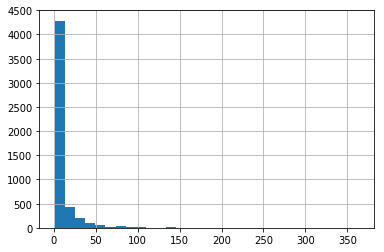

In [5]:
interactions = clean_df.groupby('email').article_id.count()
interactions.hist(bins=30)

In [6]:
interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [7]:
interactions.median()

3.0

In [8]:
interactions.quantile(q=0.95)

35.0

In mean, users interact with articles about 9 times. Most users (95% of them) interact less than 35 times, but some do interact much more. The maximum number of interactions for a user is 364.

In [9]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364  # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles
df_content.duplicated(subset='article_id').sum()

5

In [11]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
df.article_id.nunique()

714

In [13]:
df_content.article_id.nunique()

1051

In [14]:
df.email.nunique()

5148

In [15]:
df.shape[0]

45993

In [16]:
unique_articles = df.article_id.nunique()  # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()  # The number of unique articles on the IBM platform
unique_users = df.email.nunique()  # The number of unique users
user_article_interactions = df.shape[0]  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
sorted_articles = df.groupby('article_id').title.count().sort_values(ascending=False)
sorted_articles.head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: title, dtype: int64

In [18]:
most_viewed_article_id = str(sorted_articles.index[0])  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = sorted_articles.iloc[0]  # The most viewed article in the dataset was viewed how many times?

In [19]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [20]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [21]:
def sort_articles_interactions(df=df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (pandas dataframe) A dataframe with 'article_id', 'title' 
        and 'interactions' (the number of interactions).
    
    '''
    sorted_articles = df.groupby(
        ['article_id', 'title']).user_id.count().sort_values(
        ascending=False).reset_index()
    sorted_articles = sorted_articles.rename(
        columns={'user_id': 'interactions'})

    return sorted_articles

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    sorted_articles = sort_articles_interactions(df)
    top_articles = sorted_articles.iloc[:n].title.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    sorted_articles = sort_articles_interactions(df)
    top_articles = sorted_articles.iloc[:n].article_id.astype(str).tolist()
 
    return top_articles # Return the top article ids

In [22]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.pivot_table(index='user_id',
                               columns='article_id',
                               values='title',
                               aggfunc='count')
    user_item = (user_item > 0).astype('int')
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [24]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [25]:
def get_similarities(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similarities - (pandas dataframe) dataframe with the similiarity metric for
        each user, sorted descending.
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns a dataframe with the similarities.
    
    '''
    user_vec = user_item.loc[user_id, :]
    similarities = user_item.drop(user_id).dot(user_vec).sort_values(
        ascending=False)
    
    return similarities

In [26]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list
    
    '''
    similarities = get_similarities(user_id, user_item)
    most_similar_users = similarities.index.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar       

In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [28]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names =  df[
        df.article_id.isin(article_ids)
    ].title.unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.columns[
        np.where(user_item.loc[user_id, :] > 0)].astype(str).tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    seen_articles = get_user_articles(user_id)[0]
    similar_users = find_similar_users(user_id)
    recs = list()
    for user in similar_users.index:
        needed_recs = m - len(recs)
        user_articles = get_user_articles(user)[0]
        
        # Set difference, but mantaining the order
        new_articles = [a for a in user_articles 
                        if a not in (seen_articles + recs)]
        
        # Choose randomly between the last similar user articles
        if len(new_articles) > needed_recs:
            new_articles = np.random.choice(new_articles, needed_recs,
                                            replace=False).tolist()
        
        recs += new_articles
        
        if (m - len(recs)) == 0:
            break
    
    return recs # return your recommendations for this user_id    

In [29]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similarities = pd.DataFrame(get_similarities(user_id, user_item), 
                            columns=['similarity'])
    neighbors_df = similarities.join(df.groupby('user_id').count().rename(
        columns={'article_id': 'num_interactions'}).drop(
        'title', axis=1)).sort_values(['similarity', 'num_interactions'], 
                                      ascending=False)
    neighbors_df = neighbors_df.reset_index().rename(
        columns={'user_id': 'neighbor_id'})
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    seen_articles = get_user_articles(user_id)[0]
    similar_users = get_top_sorted_users(user_id)
    recs = list()
    for user in similar_users.neighbor_id:
        needed_recs = m - len(recs)
        user_articles = get_user_articles(user)[0]
        
        # Set difference, but mantaining the order
        new_articles = [a for a in user_articles 
                        if a not in (seen_articles + recs)]
        
        # Sort the articles by the number of interactions
        sub_df = df[df.article_id.isin(new_articles)]
        new_articles = get_top_article_ids(needed_recs, df=sub_df)
        
        recs += new_articles
        
        if (m - len(recs)) == 0:
            break

    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [31]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [32]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).neighbor_id[0]  # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id[9]  # Find the 10th most similar user to user 131

In [33]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Answer:**

Of the above functions only "get_top_articles" (or "get_top_article_ids") could be used, as they are the only ones that don't require user information. Those functions will simply return the most popular articles. A better way to make recommendations to a new user would be to use a Knowledge Based approach. That could be done, for example, by asking the user for some preferences of topics, and then relating those to the topics of the articles (that could be extracted from the description or required as keywords when publishing), but there are many other ways to implement a Knowledge Based recommender.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [34]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)  # Your recommendations here

In [35]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

## Content based recommendations EDA

In [36]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [37]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [38]:
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

So, let's use the full name, which has no missing values.

### Let's create a recommender based on tf-idf features

In [39]:
def get_wordnet_pos(treebank_tag):
    """
    Transforms from Treebank tags to wordnet tags.
    As discussed here:
    https://stackoverflow.com/questions/15586721/
    wordnet-lemmatization-and-pos-tagging-in-python
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # If unknown, return the default value

In [40]:
def tokenize(text):
    """ Basic tokenization function. """
    # Case normalization
    temp_text = text.lower()

    # Punctuation removal
    temp_text = re.sub(r'[^a-zA-Z0-9]', ' ', temp_text)

    # Tokenize
    tokens = word_tokenize(temp_text)

    # Stop Word Removal
    stop_words = stopwords.words("english")
    tokens = [word for word in tokens if word not in stop_words]

    # Part-of-Speech Tagging
    tokens = [(token[0], get_wordnet_pos(token[1]))
              for token in pos_tag(tokens)]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(*token) for token in tokens]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [41]:
encoder = Pipeline([
    ('vec', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
])

In [42]:
%time encoder.fit(df_content.doc_full_name.tolist())

CPU times: user 3.74 s, sys: 692 ms, total: 4.43 s
Wall time: 4.59 s


Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...y=None)), ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))])

In [43]:
X = encoder.transform(df_content.doc_full_name).toarray()

In [44]:
X.shape

(1051, 1458)

In [45]:
corrs = np.corrcoef(X)
corrs.shape

(1051, 1051)

In [46]:
%time X_cluster, idx = utils.cluster_corr(pd.DataFrame(X).T)

CPU times: user 3.64 s, sys: 63.3 ms, total: 3.7 s
Wall time: 3.64 s


/Users/antelinvestigacionydesarrollo/anaconda3/envs/data/lib/python3.6/site-packages/data_utils_mt/utils.py:80: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  clustered_ts = ts.reindex_axis(columns, axis=1)


In [47]:
X_cluster.shape

(1458, 1051)

In [48]:
corrs = X_cluster.corr()
corrs.shape

(1051, 1051)

In [49]:
corrs.isnull().sum().sum()

0

Good. There are no NaNs due to zero variance in the correlation coefficient. That's reasonable since all the titles have at least one token (unless the title only has stop words; that could be a problem...).

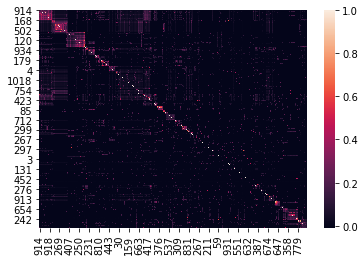

In [50]:
sns.heatmap(corrs)

In [51]:
np.unique(idx).shape

(65,)

There are some small clusters, but nothing to noteworthy.

So, let's use the correlation coefficient as distance.

## End of Content based recommendations EDA. Let's build the necessary functions

In [52]:
def get_fitted_encoder(df_content):
    """
    Returns a fitted transformer. Gets any article title and transforms it into
    an array of float values.
    """
    encoder = Pipeline([
        ('vec', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
    ])
    encoder.fit(df_content.doc_full_name.tolist())
    
    return encoder

In [53]:
def get_content_vectors(df_content, encoder):
    """
    Returns a matrix in which each row is the vector representation of the full
    name of each article.
    """
    art_vectors =  encoder.transform(df_content.doc_full_name).toarray()
    
    return pd.DataFrame(art_vectors, index=df_content.article_id)

In [54]:
def get_article_clusters(df_content, encoder):
    """
    Performs a hierarchical clustering using the correlations matrix.
    Returns the cluster ids and the mean vector for each cluster.
    """
    X = encoder.transform(df_content.doc_full_name).toarray()
    corrs = np.corrcoef(X)
    X_cluster, cluster_ids = utils.cluster_corr(pd.DataFrame(X).T)
    cluster_means = [X_cluster.T[cluster_ids == cluster_id].mean() 
                     for cluster_id in np.unique(cluster_ids)]
    
    return cluster_ids, cluster_means

In [55]:
def get_similarities(art_ids, art_names, encoder):
    """
    Gets an array of of article ids and finds the similarities with all the
    other articles for each one of them.
    
    INPUT:
        art_ids(array of int): The article ids for which the similarities are 
            to be calculated.
        art_names(array of str): The article names for which the similarities 
            are to be calculated.
        encoder(sklearn.base.BaseEstimator): A transformer that encodes the
            titles as tf-idf vectors.
        
    OUTPUT:
        similarities(dict): A dictionary with article ids in its keys. Each
        value is a dataframe with all the known article ids as index and their
        similarity to the "key" article as value.
    """
    user_vecs = encoder.transform(art_names)
    similarities = dict()
    for art_id, user_vec in zip(art_ids, user_vecs):
        similarities[art_id] = pd.DataFrame(
            art_vectors.values.dot(user_vec.toarray().T),
            index=art_vectors.index, columns=['similarity']
        ).sort_values(by='similarity', ascending=False)

    return similarities

In [56]:
def get_cluster_ranking(num_recs, cluster_ids, df_content):
    """
    Orders the article clusters by size and gets the most popular articles of
    each cluster.
    
    INPUT:
        num_recs(int): The number of recomendations expected
        cluster_ids(list): A list of cluster identifiers for the articles.
        df_content(dataframe): Dataframe that contains the information of all
            the known articles.
        
    OUTPUT:
        cluster_top(dict): A dictionary with cluster ids in its keys. Each
        value is a dataframe with all the cluster ids as index and the list of
        the most popular articles for the cluster as value.
    """
    temp_content = df_content
    temp_content['cluster_id'] = cluster_ids
    cluster_counts = temp_content.groupby('cluster_id').count().reset_index()[
        ['cluster_id', 'article_id']].rename(
        columns={'article_id':'counts'}).sort_values(
        by='counts', ascending=False)
    
    cluster_top = dict()
    for cluster in cluster_counts.index:
        cluster_art_ids = temp_content[
            temp_content.cluster_id == cluster].article_id
        cluster_top[cluster] = get_top_article_ids(
            num_recs, df[df.article_id.isin(cluster_art_ids)])

    return cluster_top

In [57]:
def select_recs(num_recs, ranked_arts):
    """
    Takes a dictionary of lists and cyclically selects one element of the list
    for each key, in order.
    INPUT:
        num_recs(int): Number of recommendations required.
        ranked_arts(dict): A dictionary of lists. The keys take priority, then
            the lists order.
    
    OUTPUT:
        rec_ids(list): List of recommendations, based on the priorities.
    """
    rec_ids = set()
    max_level = max(len(art_list) for art_list in ranked_arts.values())
    for level in range(max_level):
        for art_list in ranked_arts.values():
            if len(art_list) > level:
                rec_ids.add(int(float(art_list[level])))
            if len(rec_ids) >= num_recs:
                return list(rec_ids)
            
    return list(rec_ids)

In [58]:
def make_content_recs(user_id, views_df, encoder, cluster_ids, num_recs,
                     art_vectors):
    '''
    If the user is known, searches for articles that are similar to those seen
    by the user.
    If it is a new user, it returns the most popular articles from the biggest
    clusters.
    
    INPUT:
        user_id(int): The id of the user the recommendations are for.
        views_df(pandas dataframe): A dataframe with the user-article pairs 
            that interacted (the articles were viewed by the user)
        encoder(sklearn.base.BaseEstimator): A transformer that encodes the
            titles as tf-idf vectors.
        cluster_ids(list): A list of cluster identifiers for the articles.
        num_recs(int): The number of recommendations to return
        art_vectors(pandas dataframe): Contains the vector representation of 
        all the articles in df_content
        
    OUTPUT:
        rec_ids(list): The list of recommended article ids.
        rec_names(list): The list of recommended article's full title.
        
    '''
     
    if user_id not in views_df.user_id.tolist():  # New user. Get most popular for each cluster
        print('New user!')
        ranked_arts = get_cluster_ranking(num_recs, cluster_ids, df_content)
        
    else:  # Get similar articles
        print('Known user!')
        art_ids, art_names = get_user_articles(user_id)
        similarities = get_similarities(art_ids, art_names, encoder)
        ranked_arts = {key: value.index.tolist() 
                       for key, value in similarities.items()}
    
    rec_ids = select_recs(num_recs, ranked_arts)
    rec_names = get_article_names(rec_ids)
    
    return rec_ids, rec_names

In [59]:
# Preparation steps to run the recommendation function
encoder = get_fitted_encoder(df_content)
cluster_ids, cluster_means = get_article_clusters(df_content, encoder)
art_vectors = get_content_vectors(df_content, encoder)

/Users/antelinvestigacionydesarrollo/anaconda3/envs/data/lib/python3.6/site-packages/data_utils_mt/utils.py:80: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  clustered_ts = ts.reindex_axis(columns, axis=1)


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Answer:**

The content based recommender works differently if the user has seen any article or no.

- If the user has seen at least one article, all the known articles are sorted by similarity with the articles the user has seen. Then, the most similar articles are chosen. If there are still not enough articles, the second-most similar articles are chosen, and the third, and so on, until the required number of recommendations is reached, or all the articles are included.

- If the user has seen no article yet, the clusters are sorted by size. For each cluster the most popular articles are selected, and then the second-most similar, the third, and so on, until the required number of recommendations is reached, or all the articles are included.

Possible improvements: There are surely many. A knowledge based recommender could be used for the new users. The "select_recs" function could consider the similarity values and choose more intelligently the articles (instead of cycling, it could try to determine the "best next" in a more elaborate way).

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [60]:
# make recommendations for a brand new user
ids1, names1 = make_content_recs(0, df, encoder, cluster_ids, 10, art_vectors)
print('Recommendations for the first new user:\n')
for name in names1:
    print('*  ' + name)
print('-'*100)

ids2, names2 = make_content_recs(-20, df, encoder, cluster_ids, 10, art_vectors)
print('Recommendations for the second new user (should be the same as for the first):\n')
for name in names2:
    print('*  ' + name)
print('-'*100)

assert ids1 == ids2, 'The recommendations are NOT the same'
print('All looks good.')

New user!
Recommendations for the first new user:

*  a moving average trading strategy
*  deep learning with tensorflow course by big data university
*  tensorflow quick tips
*  deep learning with data science experience
*  analyze db2 warehouse on cloud data in rstudio in dsx
*  real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)
*  new shiny cheat sheet and video tutorial
*  data tidying in data science experience
*  what is smote in an imbalanced class setting (e.g. fraud detection)?
*  introducing ibm watson studio 
----------------------------------------------------------------------------------------------------
New user!
Recommendations for the second new user (should be the same as for the first):

*  a moving average trading strategy
*  deep learning with tensorflow course by big data university
*  tensorflow quick tips
*  deep learning with data science experience
*  analyze db2 warehouse on cloud data in rstudio in dsx
*  real-time sentiment analysis 

In [61]:
# make a recommendations for a user who only has interacted with article id '1427.0'
ids_known, names_known = make_content_recs(1427, df, encoder, cluster_ids, 10, art_vectors)
print('Recommendations for user 1427:\n')
for name in names_known:
    print('*  ' + name)
print('-'*100)

Known user!
Recommendations for user 1427:

*  learn tensorflow and deep learning together and now!
*  brunel in jupyter
*  deep learning with data science experience
*  brunel interactive visualizations in jupyter notebooks
*  brunel 2.0 preview
*  blogging with brunel
*  a classification problem
*  using bigdl in dsx for deep learning on spark
*  generalization in deep learning
----------------------------------------------------------------------------------------------------


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [62]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [63]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [64]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)  # use the built in to get the three matrices

**Answer:**

The situation is different because there is no missing data in this user-item matrix. 
That is because the values with no interactions are marked as 0, and those with interactions are marked as 1.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

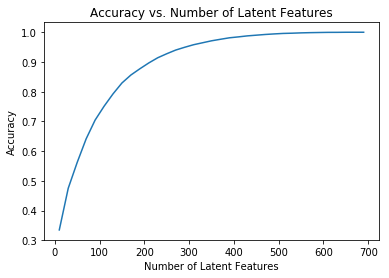

In [65]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [66]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test.user_id.unique()
    test_arts = df_test.article_id.unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [67]:
predictable_users = np.intersect1d(test_idx,
                                   user_item_train.index.values).shape[0]
print('We can make predictions for {} users in the test set, out of a total of {}.'.format(
predictable_users, test_idx.shape[0]))

We can make predictions for 20 users in the test set, out of a total of 682.


In [68]:
print('We can\'t make predictions for {} users in the test set.'.format(
test_idx.shape[0] - predictable_users))

We can't make predictions for 662 users in the test set.


In [69]:
predictable_arts = np.intersect1d(test_arts,
                                  user_item_train.columns.values).shape[0]
print('We can make predictions for {} articles in the test set, out of a total of {}.'.format(
predictable_arts, test_arts.shape[0]))

We can make predictions for 574 articles in the test set, out of a total of 574.


In [70]:
print('We can\'t make predictions for {} articles in the test set.'.format(
test_arts.shape[0] - predictable_arts))

We can't make predictions for 0 articles in the test set.


In [71]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [72]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)  # fit svd similar to above then use the cells below

In [73]:
# Use these cells to see how well you can use the training
# decomposition to predict on test data

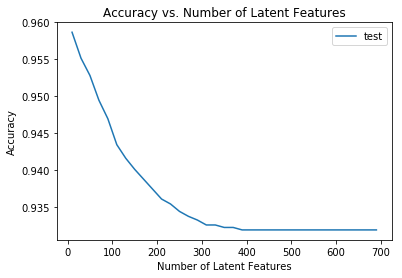

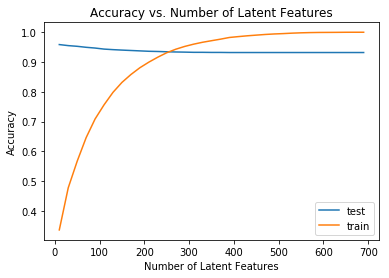

In [74]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = list()
sum_errs_train = list()

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_new_train, u_new_train, vt_new_train = s_new, u_new, vt_new
    
    # Get the filtered user-item matrix
    predictable_users = np.intersect1d(test_idx, user_item_train.index.values)
    predictable_arts = np.intersect1d(test_arts, user_item_train.columns.values)
    user_item_test_predictable = user_item_test.loc[predictable_users, 
                                                    predictable_arts]
    
    # Filter the predictable users
    predictable_usrs_idx = [user_item_train.index.get_loc(user) 
                            for user in predictable_users]
    u_new = u_new[predictable_usrs_idx, :]
    
    # Filter the predictable articles
    predictable_arts_idx = [user_item_train.columns.get_loc(art) 
                            for art in predictable_arts]
    vt_new = vt_new[:, predictable_arts_idx]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_item_est_train = np.around(np.dot(np.dot(u_new_train, s_new_train), 
                                           vt_new_train))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_predictable.values, user_item_est)
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)

plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df_test.shape[0], 
         label='test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();
plt.figure();
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df_test.shape[0], label='test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

plt.plot(num_latent_feats, 
         1 - np.array(sum_errs_train)/df_train.shape[0], 
         label='train');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Answer:**

The accuracy in the test set decreases with the number of latent features, while it increases in the train set. One possible number of latent features to choose could be the number in which both accuracies are the same, but it is just an intuitive guess. To try to determine if the recommendations are an improvement to how users currently find articles an A/B test could be performed.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [75]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0